# Comparison of predictions

- See preprocessing of gene expression and prediction were done in CaDRReS2/pipeline/* and 03_*
- Convert predicted delta to cv to cell death percentage

In [311]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from collections import Counter

sns.set(font_scale=1.5)
sns.set_style('ticks')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
from IPython.display import HTML, display

In [312]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
mpl.rc("savefig", dpi=300)

### Read data

In [313]:
dosage_shifted = False

for experimental validation

In [314]:
dosage_used = '3 fold' # All for HN, '9 fold' '3 fold' 'Median IC50' 

for calculating % cell death

In [315]:
dosage_ref = 'log2_median_ic50_hn' # log2_median_ic50_hn | log2_median_ic50_3f_hn
model_name = 'hn_drug_cw_dw10_100000_model' # hn_drug_cw_dw10_100000_model | hn_drug_cw_dw1_100000_model | hn_drug_cw_dwsim10_100000_model

Read predictions

In [316]:
current_dir = '../result/HN_model/TPM/'

# current_dir = '../result/HN_model/TMM/'
# current_dir = '../result/HN_model/TMM_p95/'
# current_dir = '../result/HN_model/mat_norm/'
# current_dir = '../result/HN_model/mat_norm_p95/'
# current_dir = '../result/HN_model/mat_norm_log2_p95/'

In [317]:
if dosage_shifted:
    pred_single_df = pd.read_csv(current_dir + 'pred_drug_kill_{}_{}_shifted.csv'.format(dosage_ref, model_name))
    pred_combi_df = pd.read_csv(current_dir + 'pred_combi_kill_{}_{}_shifted.csv'.format(dosage_ref, model_name))
else:
    pred_single_df = pd.read_csv(current_dir + 'pred_drug_kill_{}_{}.csv'.format(dosage_ref, model_name))
    pred_combi_df = pd.read_csv(current_dir + 'pred_combi_kill_{}_{}.csv'.format(dosage_ref, model_name))

In [318]:
# patient_list = ['HN120', 'HN137', 'HN148', 'HN159', 'HN160', 'HN182']
patient_list = ['HN120', 'HN137', 'HN148', 'HN159', 'HN160']

# single_drug_id_list = [1032, 1007, 133, 201, 1010] + [182, 301, 302] + [1012]
# single_drug_list = ['Afatinib', 'Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103'] + ['Vorinostat']
# combi_drug_list = ['Docetaxel|Afatinib', 'Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Epothilone B|Afatinib', 'Gefitinib|Afatinib', 'Gefitinib|Epothilone B'] + ['Afatinib|Obatoclax Mesylate', 'Epothilone B|PI-103'] + ['Doxorubicin|Vorinostat']

single_drug_id_list = [1007, 133, 201, 1010] + [182, 301, 302] + [1012]
single_drug_list = ['Docetaxel', 'Doxorubicin', 'Epothilone B', 'Gefitinib'] + ['Obatoclax Mesylate', 'PHA-793887', 'PI-103'] + ['Vorinostat']
combi_drug_list = ['Docetaxel|Epothilone B', 'Docetaxel|Gefitinib', 'Gefitinib|Epothilone B'] + ['Epothilone B|PI-103'] + ['Doxorubicin|Vorinostat']

In [319]:
# read reference dosages file
dosage_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
dosage_df = dosage_df.loc[single_drug_id_list]

####  Read experimental data

In [320]:
##### Combined replicate #####

validation_fname_list = ['../result/validation/validation_triplicate_2019_09_13.xlsx', '../result/validation/validation_replicates_2019_06_24.xlsx']

cv_single_df_list = []
cv_combi_df_list = []

for validation_fname in validation_fname_list:

    cv_single_df = pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2])
    cv_single_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
    cv_single_df = cv_single_df.reset_index().groupby(['File name', 'Dosage', 'Drug', 'Replicate']).median().reset_index() # just to rearrange columns

    cv_combi_df = pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])
    cv_combi_df.loc[:, 'File name'] = validation_fname.split('/')[-1]
    cv_combi_df = cv_combi_df.reset_index().groupby(['File name', 'Dosage', 'Drug', 'Replicate']).median().reset_index()
    
    cv_single_df_list += [cv_single_df]
    cv_combi_df_list += [cv_combi_df]

cv_df = pd.concat(cv_single_df_list + cv_combi_df_list, axis=0)
cv_df = cv_df[~cv_df['Drug'].isin(['DMSO', 'Staurosporin'])]
cv_df.head()

,File name,Dosage,Drug,Replicate,HN120,HN137,HN148,HN159,HN160,HN182
0,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,1,56.98,64.74,40.52,26.77,97.41,67.09
1,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,2,58.10,64.20,38.30,25.42,96.90,68.63
2,validation_triplicate_2019_09_13.xlsx,3 fold,Afatinib,3,53.09,59.52,35.23,24.12,93.86,66.52
6,validation_triplicate_2019_09_13.xlsx,3 fold,Docetaxel,1,81.52,71.17,84.23,86.19,88.00,67.97
7,validation_triplicate_2019_09_13.xlsx,3 fold,Docetaxel,2,80.69,67.84,78.09,81.28,86.22,70.59


In [321]:
cv_df.tail()

,File name,Dosage,Drug,Replicate,HN120,HN137,HN148,HN159,HN160,HN182
25,validation_replicates_2019_06_24.xlsx,Median IC50,Afatinib|Obatoclax Mesylate,2,22.71,32.61,11.69,14.09,67.42,26.53
26,validation_replicates_2019_06_24.xlsx,Median IC50,Epothilone B|PI-103,1,13.54,5.65,9.36,7.59,32.98,17.34
27,validation_replicates_2019_06_24.xlsx,Median IC50,Epothilone B|PI-103,2,14.10,5.68,8.73,7.46,34.33,16.63
28,validation_replicates_2019_06_24.xlsx,Median IC50,PHA-793887|Trametinib,1,5.03,16.88,15.93,16.35,26.12,10.35
29,validation_replicates_2019_06_24.xlsx,Median IC50,PHA-793887|Trametinib,2,4.14,15.13,11.70,15.93,25.38,9.85


In [322]:
#### Check consistency across triplicate #####

# validation_fname = validation_fname_list[0]

# cv_new_df = pd.concat([pd.read_excel(validation_fname, sheet_name='cv_single', index_col=[0,1,2]), pd.read_excel(validation_fname, sheet_name='cv_combi', index_col=[0,1,2])], axis=0).reset_index()
# cv_new_df = cv_new_df[~cv_new_df['Drug'].isin(['DMSO', 'Staurosporin'])]
# cv_new_df = cv_new_df.set_index(['Drug', 'Dosage', 'Replicate']).stack().reset_index()
# cv_new_df.columns = ['Drug', 'Dosage', 'Replicate', 'Patient', 'Viability']
# cv_new_df = cv_new_df.groupby(['Dosage', 'Drug', 'Patient', 'Replicate']).sum().unstack()

# sns.pairplot(cv_new_df, plot_kws={'s':10, 'alpha':0.75, 'linewidth':0}, diag_kws={'bins':20}, aspect=1.15)

Calculate % cell death at specific dosages

In [323]:
obs_kill_df = 100 - cv_df.set_index(['Dosage', 'Drug', 'File name', 'Replicate']).astype(float)
obs_kill_df = obs_kill_df.loc[dosage_used]

In [324]:
obs_kill_df.head(10)

HN120  HN137  \
Drug         File name                             Replicate                 
Afatinib     validation_triplicate_2019_09_13.xlsx 1          43.02  35.26   
                                                   2          41.90  35.80   
                                                   3          46.91  40.48   
Docetaxel    validation_triplicate_2019_09_13.xlsx 1          18.48  28.83   
                                                   2          19.31  32.16   
                                                   3          23.69  38.61   
Doxorubicin  validation_triplicate_2019_09_13.xlsx 1          33.32  42.17   
                                                   2          35.72  46.45   
                                                   3          39.04  52.38   
Epothilone B validation_triplicate_2019_09_13.xlsx 1          50.24  60.62   

                                                              HN148  HN159  \
Drug         File name                             Replicate                 
Afatinib     validation_triplicate_2019_09_13.xlsx 1          59.48  73.23   
                                                   2          61.70  74.58   
                                                   3          64.77  75.88   
Docetaxel    validation_triplicate_2019_09_13.xlsx 1          15.77  13.81   
                                                   2          21.91  18.72   
                                                   3          24.50  24.83   
Doxorubicin  validation_triplicate_2019_09_13.xlsx 1          23.79  15.58   
                                                   2          25.15  22.23   
                                                   3          31.03  25.80   
Epothilone B validation_triplicate_2019_09_13.xlsx 1          30.33  31.60   

                                                              HN160  HN182  
Drug         File name                             Replicate                
Afatinib     validation_triplicate_2019_09_13.xlsx 1           2.59  32.91  
                                                   2           3.10  31.37  
                                                   3           6.14  33.48  
Docetaxel    validation_triplicate_2019_09_13.xlsx 1          12.00  32.03  
                                                   2          13.78  29.41  
                                                   3          14.27  28.43  
Doxorubicin  validation_triplicate_2019_09_13.xlsx 1          14.64  45.80  
                                                   2          13.93  41.51  
                                                   3          17.89  45.25  
Epothilone B validation_triplicate_2019_09_13.xlsx 1          28.97  55.86

#### Read prediction

In [325]:
pred_single_df = pred_single_df[pred_single_df['drug_id'].isin(single_drug_id_list)]

pred_combi_df = pred_combi_df[pred_combi_df['drug_id_A'].isin(single_drug_id_list) & pred_combi_df['drug_id_B'].isin(single_drug_id_list)]

pred_combi_df.loc[:, 'Combi Name 1'] = pred_combi_df['drug_name_A'].values + '|' + pred_combi_df['drug_name_B'].values
pred_combi_df.loc[:, 'Combi Name 2'] = pred_combi_df['drug_name_B'].values + '|' + pred_combi_df['drug_name_A'].values

temp1 = pred_combi_df['Combi Name 1'][pred_combi_df['Combi Name 1'].isin(combi_drug_list)]
temp2 = pred_combi_df['Combi Name 2'][pred_combi_df['Combi Name 2'].isin(combi_drug_list)]
combi_name = pd.concat([temp1, temp2]).values

pred_combi_df = pd.concat([pred_combi_df[pred_combi_df['Combi Name 1'].isin(combi_drug_list)], pred_combi_df[pred_combi_df['Combi Name 2'].isin(combi_drug_list)]])
pred_combi_df.loc[:, 'Combi Name'] = combi_name
pred_combi_df = pred_combi_df[pred_combi_df['Combi Name'].isin(combi_drug_list)]

In [326]:
pred_single_df.head()

,patient,drug_id,cluster,cluster_p,cluster_delta,delta,cluster_kill,kill,drug_name
4,HN120,1007,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,3.0508057471845|2.68344052681|4.0167768343325|...,3.26,10.768034058802|13.470080993016|5.818301286009...,8.52,Docetaxel
5,HN120,1010,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,2.2212500077716|2.0557795051645|2.677399181711...,2.28,17.658569782699|19.388553836629|13.51896421525...,15.31,Gefitinib
6,HN120,1012,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-0.18193634608133|-0.10973613232891|-0.2523313...,-0.21,53.148545025719|51.900665978329|54.36145585765...,51.07,Vorinostat
24,HN120,133,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-2.7850163000908|-2.4017062802293|-1.270422554...,-1.95,87.32965858477|84.087272226485|70.694442969728...,75.63,Doxorubicin
44,HN120,182,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,-1.8025358332495|-1.1619028613393|-0.565126429...,-1.07,77.719989977921|69.112193712182|59.66956727385...,64.66,Obatoclax Mesylate


In [327]:
pred_combi_df.head()

,patient,drug_id_A,drug_name_A,drug_id_B,drug_name_B,cluster,cluster_p,cluster_kill_A,cluster_kill_B,cluster_kill_C,kill_A,kill_B,kill_C,improve,improve_p,kill_entropy,sum_kill_dif,Combi Name 1,Combi Name 2,Combi Name
9,HN120,1007,Docetaxel,201,Epothilone B,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,10.768034058802|13.470080993016|5.818301286009...,82.559569253274|75.901345747413|42.11102158023...,84.437560776083|79.147453993463|45.47917675608...,8.52,60.39,63.04,2.65,0.04,0.00,220.52,Docetaxel|Epothilone B,Epothilone B|Docetaxel,Docetaxel|Epothilone B
10,HN120,1007,Docetaxel,1010,Gefitinib,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,10.768034058802|13.470080993016|5.818301286009...,17.658569782699|19.388553836629|13.51896421525...,26.525123033003|30.246980924477|18.55069143247...,8.52,15.31,22.39,7.08,0.46,0.00,28.53,Docetaxel|Gefitinib,Gefitinib|Docetaxel,Docetaxel|Gefitinib
20,HN120,133,Doxorubicin,1012,Vorinostat,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,87.32965858477|84.087272226485|70.694442969728...,53.148545025719|51.900665978329|54.36145585765...,94.063760696756|92.346083916258|86.62537041857...,75.63,51.07,86.12,10.49,0.14,0.00,104.46,Doxorubicin|Vorinostat,Vorinostat|Doxorubicin,Doxorubicin|Vorinostat
24,HN120,201,Epothilone B,302,PI-103,D1|D2|G1|G2,0.31318681318681|0.17582417582418|0.3406593406...,82.559569253274|75.901345747413|42.11102158023...,73.319982827324|81.138919196998|93.555298867|8...,95.346890081785|95.454733348983|96.26922835189...,60.39,79.82,90.94,11.11,0.14,0.94,98.02,Epothilone B|PI-103,PI-103|Epothilone B,Epothilone B|PI-103
45,HN137,1007,Docetaxel,201,Epothilone B,E1|E2|E3|F1|F2|F3,0.34090909090909|0.085227272727273|0.073863636...,19.585333371545|16.02760069062|12.861596918384...,62.407833255845|16.012617329511|38.76244513162...,69.770384434275|29.47377965444|46.638572601469...,14.76,46.72,53.85,7.14,0.15,0.44,145.97,Docetaxel|Epothilone B,Epothilone B|Docetaxel,Docetaxel|Epothilone B


### Comparison

In [328]:
pred_single_kill_df = pred_single_df[['patient', 'drug_name', 'kill']].pivot(index='drug_name', columns='patient', values='kill')
pred_single_delta_df = pred_single_df[['patient', 'drug_name', 'delta']].pivot(index='drug_name', columns='patient', values='delta')
pred_combi_kill_df = pred_combi_df[['patient', 'Combi Name', 'kill_C']].pivot(index='Combi Name', columns='patient', values='kill_C')

obs_single_kill_df = obs_kill_df.loc[single_drug_list, patient_list]
obs_combi_kill_df = obs_kill_df.loc[combi_drug_list, patient_list]

In [329]:
sns.set(font_scale=1.25)
sns.set_style('ticks')

cmap = plt.cm.get_cmap('tab10', 10)
colors = cmap(np.linspace(0, 1, 10))
patient_color_dict = dict(zip(patient_list, colors[0:len(patient_list)]))
drug_color_dict = dict(zip(single_drug_list, colors[0:len(single_drug_list)]))
combi_color_dict = dict(zip(combi_drug_list, colors[0:len(combi_drug_list)]))

drug_marker_dict = dict(zip(single_drug_list, ['o', 'v', '^', '<', '>', 'd', 's']))
combi_marker_dict = dict(zip(combi_drug_list, ['p', '*', 'P', 'X', 'h']))

#### For single drug

In [330]:
obs_df = obs_single_kill_df.loc[single_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug', 'File name', 'Replicate', 'Patient', 'Observed % cell death']
print (obs_df.shape)

pred_df = pred_single_kill_df.loc[[d[0] for d in obs_single_kill_df.index], patient_list].stack().reset_index()
pred_df.columns = ['Drug', 'Patient', 'Predicted % cell death']
print (pred_df.shape)

scatter_single_df = pd.concat([obs_df, pred_df[['Predicted % cell death']]], axis=1)
scatter_single_df.loc[:, 'Replicate'] = scatter_single_df['Replicate'].astype(str)
print (scatter_single_df.shape)
scatter_single_df.tail()

(125, 5)
(125, 3)
(125, 6)


,Drug,File name,Replicate,Patient,Observed % cell death,Predicted % cell death
120,PI-103,validation_replicates_2019_06_24.xlsx,2,HN120,72.39,79.82
121,PI-103,validation_replicates_2019_06_24.xlsx,2,HN137,77.52,53.50
122,PI-103,validation_replicates_2019_06_24.xlsx,2,HN148,81.74,64.17
123,PI-103,validation_replicates_2019_06_24.xlsx,2,HN159,84.66,85.69
124,PI-103,validation_replicates_2019_06_24.xlsx,2,HN160,51.99,83.75


In [331]:
scatter_single_df.groupby(['Drug', 'Patient']).agg(['min', 'max', 'median']).head()

Observed % cell death               Predicted % cell death  \
                                    min    max median                    min   
Drug      Patient                                                              
Docetaxel HN120                   15.94  31.06  19.31                   8.52   
          HN137                    9.41  38.61  32.16                  14.76   
          HN148                   15.77  31.33  22.87                   7.05   
          HN159                   13.81  24.83  18.72                   8.05   
          HN160                    1.91  14.27  12.00                   9.65   

                                 
                     max median  
Drug      Patient                
Docetaxel HN120     8.52   8.52  
          HN137    14.76  14.76  
          HN148     7.05   7.05  
          HN159     8.05   8.05  
          HN160     9.65   9.65

Single drug | Pearson r = 0.66 (3.59e-06)
Single drug [R-sq 33.06%]


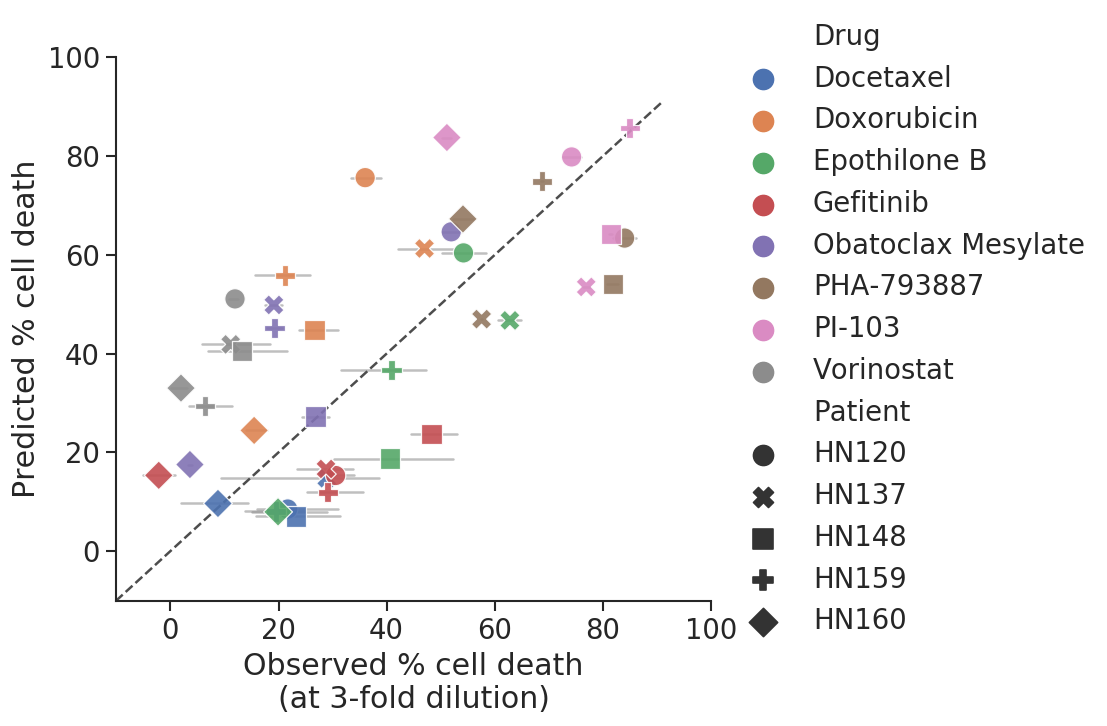

In [332]:
sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=scatter_single_df.groupby(['Drug', 'Patient']).mean().reset_index(), x='Observed % cell death', y='Predicted % cell death', hue='Drug', style='Patient', s=150, alpha=0.9, ax=ax)

for _, row in scatter_single_df.groupby(['Drug', 'Patient']).agg(['min', 'max', 'median']).iterrows():
    ax.plot([row[('Observed % cell death', 'min')], row[('Observed % cell death', 'max')]], 
            [row[('Predicted % cell death', 'median')], row[('Predicted % cell death', 'median')]], 
            color='grey', zorder=0, alpha=0.5)
    

vmin = scatter_single_df[['Observed % cell death', 'Predicted % cell death']].min().min()
vmax = scatter_single_df[['Observed % cell death', 'Predicted % cell death']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, 100))
ax.set_ylim((vmin-5, 100))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=2)

x = scatter_single_df.groupby(['Drug', 'Patient']).mean().reset_index()['Observed % cell death'].values
y = scatter_single_df.groupby(['Drug', 'Patient']).mean().reset_index()['Predicted % cell death'].values

scor, pval = stats.pearsonr(x, y)
print ('Single drug | Pearson r = {:.2f} ({:.2e})'.format(scor, pval))

r2 = metrics.r2_score(x, y)
print ('Single drug [R-sq {:.2f}%]'.format(r2*100))

if dosage_used == 'Median IC50':
    ax.set_xlabel('Observed % cell death\n(at drug-specific dosage)')
elif dosage_used == '3 fold':
    ax.set_xlabel('Observed % cell death\n(at 3-fold dilution)')
else:
    ax.set_xlabel('Observed % cell death\n({})'.format(dosage_used))

sns.despine()

fig.savefig('../figure/Fig4E_single_drug_{}.svg'.format(dosage_used))

In [333]:
# drug_list = sorted(list(set(scatter_df['Drug'])))
# for drug in drug_list:
#     d_y = scatter_df[scatter_df['Drug']==drug]['Observed % cell death'].values
#     d_y_hat = scatter_df[scatter_df['Drug']==drug]['Predicted % cell death'].values
#     print ("{} [R-sq = {:.2f}%]".format(drug, metrics.r2_score(d_y, d_y_hat)*100))

In [334]:
# patient_list = sorted(list(set(scatter_df['Patient'])))
# for patient in patient_list:
#     d_y = scatter_df[scatter_df['Patient']==patient]['Observed % cell death'].values
#     d_y_hat = scatter_df[scatter_df['Patient']==patient]['Predicted % cell death'].values
#     print ("{} [R-sq = {:.2f}%]".format(patient, metrics.r2_score(d_y, d_y_hat)*100))

#### For combi drug

In [335]:
obs_df = obs_combi_kill_df.loc[combi_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug combination', 'File name', 'Replicate', 'Patient', 'Observed % cell death']
print (obs_df.shape)

pred_df = pred_combi_kill_df.loc[[d[0] for d in obs_combi_kill_df.index], patient_list].stack().reset_index()
pred_df.columns = ['Drug combination', 'Patient', 'Predicted % cell death']
print (pred_df.shape)

scatter_combi_df = pd.concat([obs_df, pred_df[['Predicted % cell death']]], axis=1)
scatter_combi_df.loc[:, 'Replicate'] = scatter_combi_df['Replicate'].astype(str)
print (scatter_combi_df.shape)
scatter_combi_df.tail()

(70, 5)
(70, 3)
(70, 6)


,Drug combination,File name,Replicate,Patient,Observed % cell death,Predicted % cell death
65,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN120,82.03,90.94
66,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN137,90.08,73.27
67,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN148,85.65,70.84
68,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN159,88.91,90.32
69,Epothilone B|PI-103,validation_replicates_2019_06_24.xlsx,2,HN160,55.05,85.20


Drug combination | 0.58 (2.30e-03)
Drug combination [R-sq 7.48%]


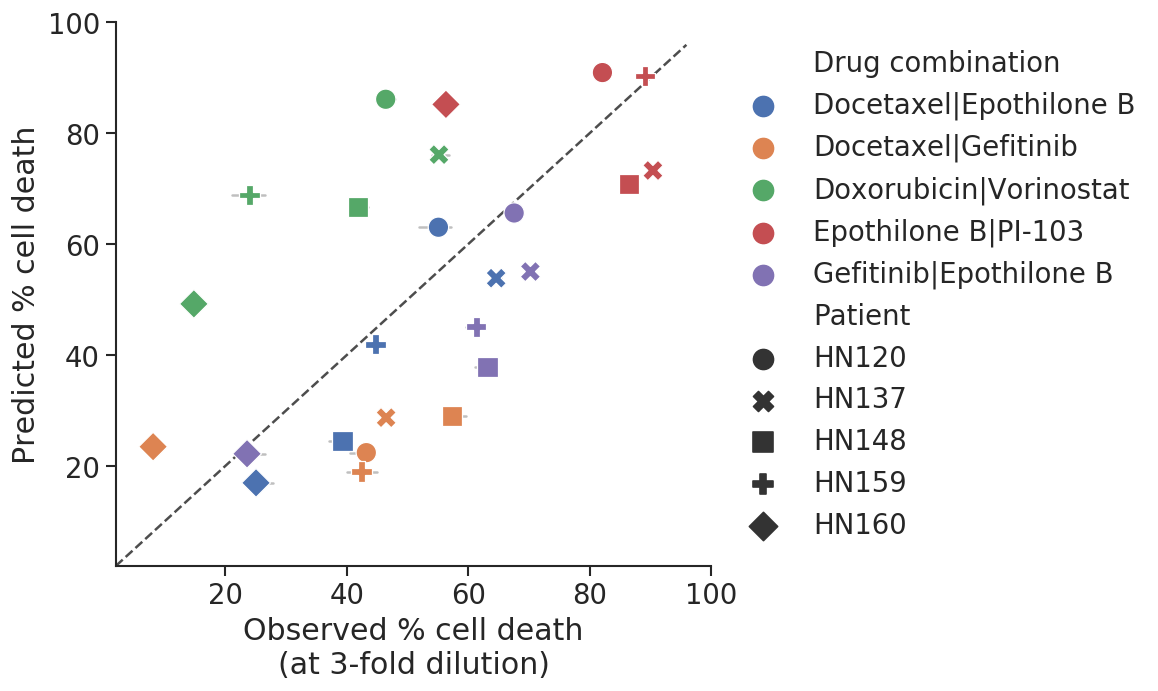

In [336]:
sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=scatter_combi_df.groupby(['Drug combination', 'Patient']).mean().reset_index(), x='Observed % cell death', y='Predicted % cell death', hue='Drug combination', style='Patient', s=150, alpha=1.0)

for _, row in scatter_combi_df.groupby(['Drug combination', 'Patient']).agg(['min', 'max', 'median']).iterrows():
    ax.plot([row[('Observed % cell death', 'min')], row[('Observed % cell death', 'max')]], 
            [row[('Predicted % cell death', 'median')], row[('Predicted % cell death', 'median')]], 
            color='grey', zorder=0, alpha=0.5)

vmin = scatter_combi_df[['Observed % cell death', 'Predicted % cell death']].min().min()
vmax = scatter_combi_df[['Observed % cell death', 'Predicted % cell death']].max().max()

ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
ax.set_xlim((vmin-5, 100))
ax.set_ylim((vmin-5, 100))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=2)

x = scatter_combi_df.groupby(['Drug combination', 'Patient']).mean().reset_index()['Observed % cell death'].values
y = scatter_combi_df.groupby(['Drug combination', 'Patient']).mean().reset_index()['Predicted % cell death'].values

scor, pval = stats.pearsonr(x, y)
print ('Drug combination | {:.2f} ({:.2e})'.format(scor, pval))

r2 = metrics.r2_score(x, y)
print ('Drug combination [R-sq {:.2f}%]'.format(r2*100))

if dosage_used == 'Median IC50':
    ax.set_xlabel('Observed % cell death\n(at drug-specific dosage)')
if dosage_used == '3 fold':
    ax.set_xlabel('Observed % cell death\n(at 3-fold dilution)')
else:
    ax.set_xlabel('Observed % cell death\n({})'.format(dosage_used))

sns.despine()

fig.savefig('../figure/Fig4_combi_drug_{}.svg'.format(dosage_used))

##### Barchart for single vs combi

In [337]:
selected_patient = 'HN137' # HN137, HN120, HN148, HN159, HN160

In [338]:
obs_bar_list = []

for _, row in scatter_combi_df[scatter_combi_df['Patient']==selected_patient].iterrows():
    combi_name = row['Drug combination']
    combi_kills = row['Observed % cell death']
    
    drug_a, drug_b = combi_name.split('|')
    combi_name = '{}\n{}'.format(drug_a, drug_b)
    
    drug_a_kills = scatter_single_df[(scatter_single_df['Patient']==selected_patient) & (scatter_single_df['Drug']==drug_a)]['Observed % cell death'].values
    drug_b_kills = scatter_single_df[(scatter_single_df['Patient']==selected_patient) & (scatter_single_df['Drug']==drug_b)]['Observed % cell death'].values
    
    for drug_a_kill in drug_a_kills:
        obs_bar_list += [['A', drug_a_kill, combi_name]]
    for drug_b_kill in drug_b_kills:
        obs_bar_list += [['B', drug_b_kill, combi_name]]
    
    if type(row['Observed % cell death']) is float:
        obs_bar_list += [['C', combi_kills, combi_name]]
    else:
        for combi_kill in combi_kills:
            obs_bar_list += [['C', combi_kill, combi_name]]

obs_bar_df = pd.DataFrame(obs_bar_list, columns=['drug_name', 'kill', 'combi_name'])

In [339]:
# sorted_combi_list = obs_bar_df[obs_bar_df['drug_name']=='C'].groupby('combi_name').mean().sort_values('kill').index
sorted_combi_list = ['Docetaxel\nGefitinib', 'Doxorubicin\nVorinostat',
       'Docetaxel\nEpothilone B', 'Gefitinib\nEpothilone B',
       'Epothilone B\nPI-103']

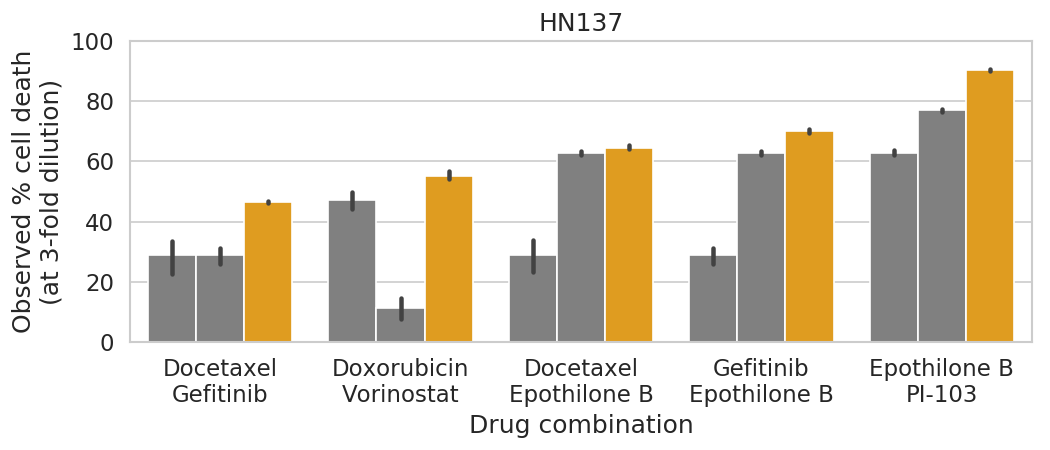

In [340]:
sns.set(font_scale=1.25, style='whitegrid')
fig, ax = plt.subplots(figsize=(9, 4))

clrs = ['orange' if d == 'C' else 'grey' for d in obs_bar_df.groupby(['combi_name', 'drug_name']).mean().reset_index()['drug_name'].values]

sns.barplot(data=obs_bar_df, x='combi_name', y='kill', hue='drug_name', order=sorted_combi_list, palette=clrs)
ax.set_ylim((0, 100))

ax.get_legend().remove()
if dosage_used == '3 fold':
    ax.set_ylabel('Observed % cell death\n(at 3-fold dilution)')
else:
    ax.set_ylabel('Observed % cell death\n({})'.format(dosage_used))
ax.set_xlabel('Drug combination')
ax.set_title(selected_patient)
plt.tight_layout()
fig.savefig('../figure/Fig4_single_combi_{}_{}_obs.svg'.format(dosage_used, selected_patient))


In [341]:
pred_bar_list = []

for _, row in scatter_combi_df[scatter_combi_df['Patient']==selected_patient].iterrows():
    combi_name = row['Drug combination']
    combi_kill = row['Predicted % cell death']
    
    drug_a, drug_b = combi_name.split('|')
    combi_name = '{}\n{}'.format(drug_a, drug_b)
    
    drug_a_kill = scatter_single_df[(scatter_single_df['Patient']==selected_patient) & (scatter_single_df['Drug']==drug_a)]['Predicted % cell death'].values.mean()
    drug_b_kill = scatter_single_df[(scatter_single_df['Patient']==selected_patient) & (scatter_single_df['Drug']==drug_b)]['Predicted % cell death'].values.mean()
    
    pred_bar_list += [['A', drug_a_kill, combi_name]]
    pred_bar_list += [['B', drug_b_kill, combi_name]]
    pred_bar_list += [['C', combi_kill, combi_name]]

pred_bar_df = pd.DataFrame(pred_bar_list, columns=['drug_name', 'kill', 'combi_name'])

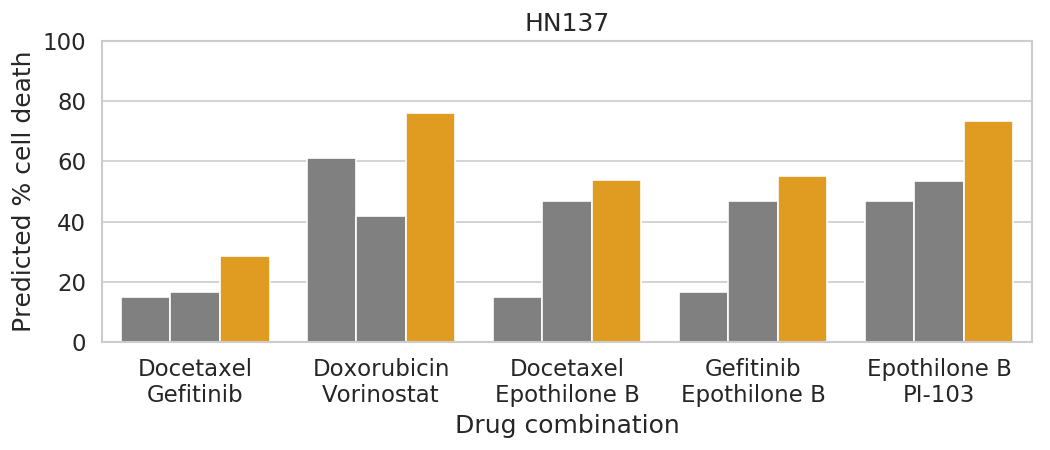

In [356]:
sns.set(font_scale=1.25, style='whitegrid')
fig, ax = plt.subplots(figsize=(9, 4))

clrs = ['orange' if d == 'C' else 'grey' for d in pred_bar_df['drug_name'].values]
sns.barplot(data=pred_bar_df, x='combi_name', y='kill', hue='drug_name', order=sorted_combi_list, palette=clrs, ci=None)
ax.set_ylim((0, 100))

ax.get_legend().remove()
ax.set_ylabel('Predicted % cell death')
ax.set_xlabel('Drug combination')
ax.set_title(selected_patient)
plt.tight_layout()
fig.savefig('../figure/Fig4_single_combi_{}_pred.svg'.format(selected_patient))

### Compare improvement of drug combi over single drugs

In [343]:
pred_combi_imp_df = pred_combi_df[['patient', 'Combi Name', 'improve']].pivot(index='Combi Name', columns='patient', values='improve')
pred_combi_pimp_df = pred_combi_df[['patient', 'Combi Name', 'improve_p']].pivot(index='Combi Name', columns='patient', values='improve_p')

pred_combi_imp_df = pred_combi_imp_df.loc[combi_drug_list, patient_list]
pred_combi_pimp_df = pred_combi_pimp_df.loc[combi_drug_list, patient_list]

In [344]:
pred_combi_imp_df

patient,HN120,HN137,HN148,HN159,HN160
Combi Name,,,,,
Docetaxel|Epothilone B,2.65,7.14,5.74,5.29,7.29
Docetaxel|Gefitinib,7.08,12.08,5.34,7.04,8.12
Gefitinib|Epothilone B,5.22,8.33,14.13,8.40,6.84
Epothilone B|PI-103,11.11,19.78,6.67,4.63,1.44
Doxorubicin|Vorinostat,10.49,14.86,21.94,13.02,16.20


In [345]:
# TEMPORARY: using averge response

temp_df = obs_kill_df.loc[combi_drug_list].reset_index().drop(['File name', 'Replicate'], axis=1)
temp_df = temp_df.groupby('Drug').mean()
# temp_df = temp_df.loc[~temp_df.index.duplicated(keep='first')]
temp_df

,HN120,HN137,HN148,HN159,HN160,HN182
Drug,,,,,,
Docetaxel|Epothilone B,55.10,64.60,39.32,44.73,25.05,60.92
Docetaxel|Gefitinib,43.22,46.48,57.34,42.40,8.10,37.92
Doxorubicin|Vorinostat,46.41,55.18,41.84,23.98,14.82,56.37
Epothilone B|PI-103,82.10,90.42,86.49,89.11,56.33,40.31
Gefitinib|Epothilone B,67.57,70.24,63.18,61.33,23.57,66.17


In [346]:
imp_results = []
pimp_results = []
for c, data in temp_df.loc[combi_drug_list, patient_list].iterrows():
    a, b = c.split('|')
    
    c_kill = data.values
    best_kill = obs_kill_df.loc[[a, b]].max()[patient_list]
#     best_kill = obs_kill_df.loc[[a, b]].reset_index().groupby('Drug').mean()[patient_list].max()
    
#     print (c, c_kill, best_kill)
    
    imp = list((c_kill - best_kill).values)
    pimp = list(((c_kill - best_kill)/best_kill).values)
    
    imp_results += [[c] + imp]
    pimp_results += [[c] + pimp]
        
obs_combi_imp_df = pd.DataFrame(imp_results)
obs_combi_imp_df.columns = ['Drug combination'] + patient_list
obs_combi_imp_df = obs_combi_imp_df.set_index('Drug combination')

obs_combi_pimp_df = pd.DataFrame(pimp_results)
obs_combi_pimp_df.columns = ['Drug combination'] + patient_list
obs_combi_pimp_df = obs_combi_pimp_df.set_index('Drug combination')

obs_combi_imp_df = obs_combi_imp_df.loc[combi_drug_list, patient_list]
obs_combi_pimp_df = obs_combi_pimp_df.loc[combi_drug_list, patient_list]

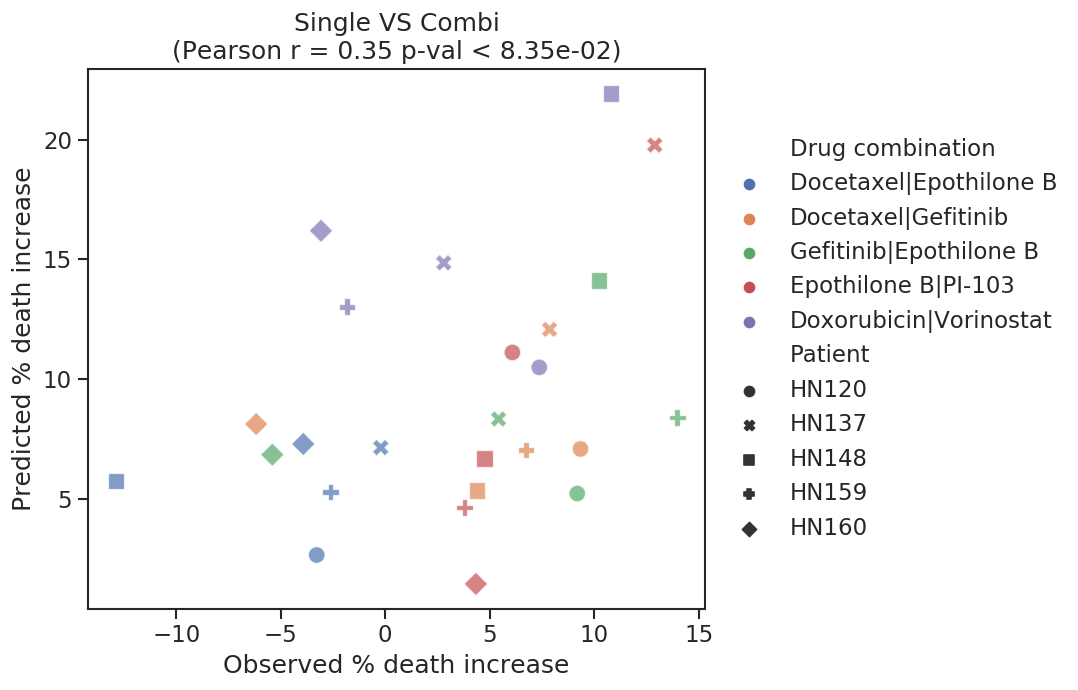

In [347]:
obs_df = obs_combi_imp_df.loc[combi_drug_list, patient_list].stack().reset_index()
obs_df.columns = ['Drug combination', 'Patient', 'Observed % death increase']

pred_df = pred_combi_imp_df.loc[combi_drug_list, patient_list].stack().reset_index()
pred_df.columns = ['Drug combination', 'Patient', 'Predicted % death increase']

sns.set(font_scale=1.25, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))
scatter_df = pd.merge(obs_df, pred_df, left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])

sns.scatterplot(data=scatter_df, x='Observed % death increase', y='Predicted % death increase', hue='Drug combination', style='Patient', s=100, alpha=0.7)
# sns.regplot(data=scatter_df, x='Observed % death increase', y='Predicted % death increase', x_ci='ci', ci=99, scatter=False, color='grey')
# plt.plot([0, 25], [0, 25], ls="--", c=".3")

vmin = scatter_df[['Observed % death increase', 'Predicted % death increase']].min().min()
vmax = scatter_df[['Observed % death increase', 'Predicted % death increase']].max().max()

# ax.plot([vmin-5, vmax+5], [vmin-5, vmax+5], ls="--", c=".3", zorder=0)
# ax.set_xlim((vmin-5, vmax+5))
# ax.set_ylim((vmin-5, vmax+5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

scor, pval = stats.pearsonr(obs_df['Observed % death increase'].values, pred_df['Predicted % death increase'].values)
ax.set_title('Single VS Combi\n(Pearson r = {:.2f} p-val < {:.2e})'.format(scor, pval))

# r2 = metrics.r2_score(scatter_df['Observed % death increase'].values, scatter_df['Predicted % death increase'].values)
# ax.set_title('Single VS Combi [R-sq {:.2f}%]'.format(r2*100))

plt.tight_layout()
fig.savefig('../figure/Fig4_improvement_{}_scatter.svg'.format(dosage_used))

In [348]:
def change_boxplot_edge_color(ax, col):
    for i, artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor(col)
        # artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

In [349]:
cutoff = 5

RanksumsResult(statistic=2.025560935370028, pvalue=0.0428097981258424) Ttest_indResult(statistic=2.0216763741780417, pvalue=0.05499427653602099)


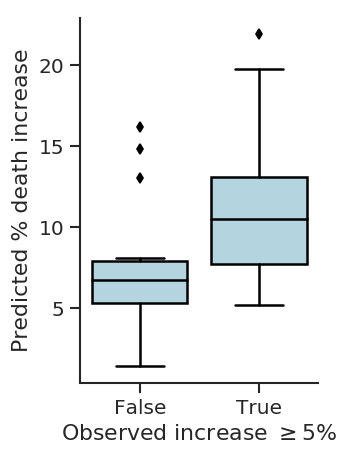

In [350]:
sns.set(font_scale=1.1, style='ticks')
fig, ax = plt.subplots(figsize=(3, 4))

merge_df = pd.merge(obs_df, pred_df, left_on=['Drug combination', 'Patient'], right_on=['Drug combination', 'Patient'])
merge_df.loc[:, 'Observed increase'] = merge_df['Observed % death increase'] >= cutoff

sns.boxplot(data=merge_df, x='Observed increase', y='Predicted % death increase', fliersize=4, color='lightblue', ax=ax)
# sns.swarmplot(data=merge_df, x='Observed increase', y='Predicted % death increase', color='black', alpha=0.5, ax=ax)
change_boxplot_edge_color(ax, 'black')
ax.set_xlabel('Observed increase ' + r'$\geq {}\%$'.format(cutoff))

x = merge_df.loc[merge_df['Observed increase'], 'Predicted % death increase'].values
y = merge_df.loc[~merge_df['Observed increase'], 'Predicted % death increase'].values

sns.despine()
print (stats.ranksums(x, y), stats.ttest_ind(x, y))
plt.tight_layout()

fig.savefig('../figure/Fig4_improvement_{}_{}.svg'.format(dosage_used, cutoff))

In [351]:
obs = (merge_df['Observed % death increase'].values >= cutoff).astype(int)
pred = (merge_df['Predicted % death increase'].values >= cutoff).astype(int)
pred_val = merge_df['Predicted % death increase'].values

Counter(obs)

Counter({0: 14, 1: 11})

In [352]:
metrics.accuracy_score(obs, pred), metrics.f1_score(obs, pred, pos_label=1), metrics.f1_score(obs, pred, pos_label=0)

(0.56, 0.6666666666666666, 0.35294117647058826)

0.6739128295946478


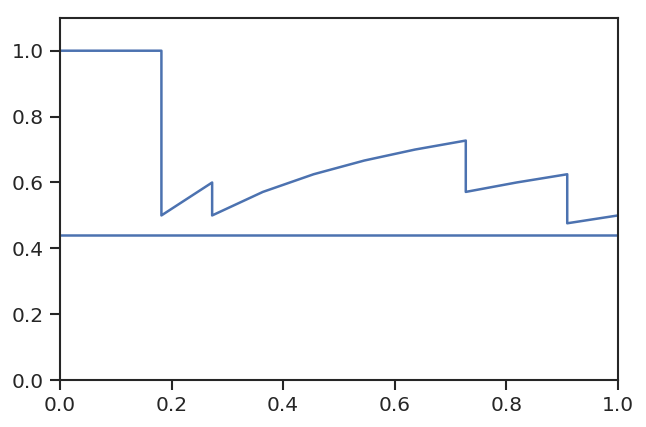

In [353]:
precision, recall, thresholds = metrics.precision_recall_curve(obs, pred_val)
plt.plot(recall, precision)

print (metrics.auc(recall, precision))

no_skill = len(obs[obs==1]) / len(obs)
plt.axhline(y=no_skill)

plt.xlim((0,1))
plt.ylim((0,1.1))

fig.savefig('../figure/Fig4_pr_curve_{}_{}.svg'.format(dosage_used, cutoff))